In [1]:
import math
import numpy as np
from numpy import *
from os import path
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

In [ ]:
plt.rc('text', usetex=True)

inpath = "../../"

currentfile = "Imitator_2_2400.csv"

# Read from file
strdatatype = np.dtype([('N', np.int_, (2,)), ('Time_Count', np.int_ ), ('Mode', np.int_ ),
                            ('T', np.float_, (10,)), ('S', np.bool_, (10,)), ('System_State', np.bool_ )])
N, Time_Count, Mode, T, S, System_State = np.loadtxt(path.join(inpath, currentfile),
        unpack=True, delimiter=';', skiprows=1, dtype=strdatatype)

In [ ]:
def slice_enc(_data_full, _now, _depth):
    '''
    returns slice of inintial array to pass it to LSTM input on one given timestamp
    '''
    data_slice = _data_full[_now - _depth: _now,:]
    return data_slice

def slice_pred(_data_full, _now, _depth):
    '''
    returns slice of inintial array to pass it to LSTM input on one given timestamp
    '''
    data_slice = _data_full[_now: _now + _depth]
    return data_slice


In [ ]:
pred_steps = 20

first_n = N[0,0] 
last_n = N[-1,-1]

val_pred_start = last_n - pred_steps + 1
val_pred_end = last_n
val_enc_start = first_n + pred_steps +1
val_enc_end = last_n - pred_steps

train_enc_start = first_n
train_enc_end = last_n - 2 * pred_steps
train_pred_start = last_n - 2 * pred_steps + 1
train_pred_end = last_n - pred_steps

In [5]:
latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]               

In [9]:
epochs = 300

sliced_T_enc = np.transpose(T[train_enc_start:train_enc_end,:])
encoder_input_data = sliced_T_enc.reshape(sliced_T_enc.shape[0], sliced_T_enc.shape[1], 1)
sliced_T_pred = np.transpose(T[train_pred_start:train_pred_end,:])
decoder_target_data = sliced_T_pred.reshape(sliced_T_pred.shape[0], sliced_T_pred.shape[1], 1)


# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]


model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=epochs, validation_split=0.2)

Train on 8 samples, validate on 2 samples
Epoch 1/300
8/8 [==============================] - 6s 764ms/step - loss: 37.0907 - val_loss: 29.7586
Epoch 2/300
8/8 [==============================] - 5s 609ms/step - loss: 37.0219 - val_loss: 29.6828
Epoch 3/300
8/8 [==============================] - 4s 545ms/step - loss: 36.7903 - val_loss: 29.6080
Epoch 4/300
8/8 [==============================] - 5s 598ms/step - loss: 36.8183 - val_loss: 29.5337
Epoch 5/300
8/8 [==============================] - 5s 580ms/step - loss: 36.8286 - val_loss: 29.4598
Epoch 6/300
8/8 [==============================] - 5s 582ms/step - loss: 36.5839 - val_loss: 29.3861
Epoch 7/300
8/8 [==============================] - 5s 577ms/step - loss: 36.6250 - val_loss: 29.3124
Epoch 8/300
8/8 [==============================] - 4s 561ms/step - loss: 36.4913 - val_loss: 29.2387
Epoch 9/300
8/8 [==============================] - 4s 551ms/step - loss: 36.4721 - val_loss: 29.1644
Epoch 10/300
8/8 [==============================]

Epoch 81/300
8/8 [==============================] - 4s 539ms/step - loss: 31.8695 - val_loss: 24.7258
Epoch 82/300
8/8 [==============================] - 4s 511ms/step - loss: 31.8057 - val_loss: 24.6675
Epoch 83/300
8/8 [==============================] - 5s 570ms/step - loss: 31.7490 - val_loss: 24.6083
Epoch 84/300
8/8 [==============================] - 5s 594ms/step - loss: 31.7127 - val_loss: 24.5482
Epoch 85/300
8/8 [==============================] - 5s 650ms/step - loss: 31.6380 - val_loss: 24.4870
Epoch 86/300
8/8 [==============================] - 5s 610ms/step - loss: 31.5885 - val_loss: 24.4249
Epoch 87/300
8/8 [==============================] - 5s 585ms/step - loss: 31.5200 - val_loss: 24.3619
Epoch 88/300
8/8 [==============================] - 5s 625ms/step - loss: 31.4536 - val_loss: 24.2981
Epoch 89/300
8/8 [==============================] - 4s 502ms/step - loss: 31.4141 - val_loss: 24.2341
Epoch 90/300
8/8 [==============================] - 5s 601ms/step - loss: 31.3574 

Epoch 161/300
8/8 [==============================] - 5s 591ms/step - loss: 27.3518 - val_loss: 20.2210
Epoch 162/300
8/8 [==============================] - 5s 590ms/step - loss: 27.2955 - val_loss: 20.1680
Epoch 163/300
8/8 [==============================] - 5s 643ms/step - loss: 27.2560 - val_loss: 20.1150
Epoch 164/300
8/8 [==============================] - 5s 602ms/step - loss: 27.2027 - val_loss: 20.0621
Epoch 165/300
8/8 [==============================] - 5s 621ms/step - loss: 27.1430 - val_loss: 20.0091
Epoch 166/300
8/8 [==============================] - 5s 624ms/step - loss: 27.0835 - val_loss: 19.9562
Epoch 167/300
8/8 [==============================] - 5s 622ms/step - loss: 27.0437 - val_loss: 19.9033
Epoch 168/300
8/8 [==============================] - 5s 625ms/step - loss: 26.9907 - val_loss: 19.8505
Epoch 169/300
8/8 [==============================] - 5s 574ms/step - loss: 26.9344 - val_loss: 19.7976
Epoch 170/300
8/8 [==============================] - 5s 592ms/step - loss

Epoch 241/300
8/8 [==============================] - 4s 534ms/step - loss: 23.1502 - val_loss: 16.0200
Epoch 242/300
8/8 [==============================] - 4s 545ms/step - loss: 23.1022 - val_loss: 15.9679
Epoch 243/300
8/8 [==============================] - 5s 564ms/step - loss: 23.0490 - val_loss: 15.9158
Epoch 244/300
8/8 [==============================] - 4s 507ms/step - loss: 22.9883 - val_loss: 15.8637
Epoch 245/300
8/8 [==============================] - 5s 569ms/step - loss: 22.9483 - val_loss: 15.8117
Epoch 246/300
8/8 [==============================] - 5s 612ms/step - loss: 22.8884 - val_loss: 15.7596
Epoch 247/300
8/8 [==============================] - 4s 553ms/step - loss: 22.8419 - val_loss: 15.7076
Epoch 248/300
8/8 [==============================] - 4s 547ms/step - loss: 22.7876 - val_loss: 15.6555
Epoch 249/300
8/8 [==============================] - 5s 580ms/step - loss: 22.7344 - val_loss: 15.6035
Epoch 250/300
8/8 [==============================] - 5s 579ms/step - loss

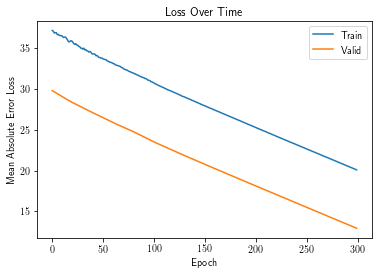

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])